# Прогнозирование оттока клиентов банка

## **Цель**:
Разработать модель машинного обучения для прогнозирования оттока клиентов банка на основе их характеристик, чтобы помочь бизнесу снизить потери и улучшить стратегии удержания клиентов.

---
## **Описание проекта**
**Построение модели прогнозирования оттока клиентов:**
   - Построение и сравнение классических моделей машинного обучения (логистическая регрессия, случайный лес, градиентный бустинг и др.).
   - Оптимизация гиперпараметров и оценка качества моделей с учетом дисбаланса классов.

Источник данных:
https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset?resource=download

---

## **Вопросы**
1. **Подготовка данных:**
   - Как кодировать категориальные признаки (country, gender)?
   - Нужно ли масштабировать числовые признаки (age, balance)?

2. **Борьба с дисбалансом:**
   - Какой метод лучше: oversampling (SMOTE), undersampling или веса классов?
   - Какие метрики (F1, ROC-AUC) использовать для оценки качества?

3. **Выбор модели:**
   - Какая модель (логистическая регрессия, случайный лес, XGBoost) дает лучший результат?
   - Как сравнить важность признаков в разных моделях?

4. **Оптимизация:**
   - Какие гиперпараметры (глубина деревьев, learning rate) улучшают качество?
   - Как использовать кросс-валидацию для оценки устойчивости модели?

5. **Оценка:**
   - Какая модель лучше работает на тестовой выборке: точность vs полнота?
   - Как интерпретировать матрицу ошибок для бизнеса?

6. **Деплоймент:**
   - Какие признаки наиболее критичны для прогноза?
   - Можно ли упростить модель без потери качества?

---
## **Описание полей таблицы**

1. **customer_id** (Идентификатор клиента)
   - Уникальный идентификатор клиента в системе банка.

2. **credit_score** (Кредитный рейтинг)
   - Числовой показатель, отражающий кредитоспособность клиента (чем выше, тем лучше).

3. **country** (Страна)
   - Страна проживания клиента (например, Германия, Франция, Испания).

4. **gender** (Пол)
   - Пол клиента (мужчина/женщина).

5. **age** (Возраст)
   - Возраст клиента в годах.

6. **tenure** (Срок сотрудничества)
   - Количество лет, в течение которых клиент пользуется услугами банка.

7. **balance** (Баланс на счете)
   - Сумма денег на счете клиента.

8. **products_number** (Количество продуктов)
   - Количество банковских продуктов, которыми пользуется клиент (например, депозит, кредит, ипотека).

9. **credit_card** (Наличие кредитной карты)
   - Бинарный признак: 1 — у клиента есть кредитная карта, 0 — нет.

10. **active_member** (Активный клиент)
    - Бинарный признак: 1 — клиент активно пользуется услугами банка, 0 — неактивен.

11. **estimated_salary** (Предполагаемая зарплата)
    - Оценка годового дохода клиента.

12. **churn** (Отток)
    - Целевая переменная: 1 — клиент ушел из банка, 0 — клиент остался.

Импортируем библиотеки:

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Чтение данных и определение функции для диагностики df:

In [60]:
# чтение
df_ml = pd.read_csv('data\\bank_customer_a.csv', sep = ',')

# определение функции
def df_diagnostics(df1, target_col=None, iqr_coefficient=1.5):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'min': lambda s: s.min(),
        '25%': lambda s: s.quantile(0.25), # 25% квартиль
        '50%': lambda s: s.quantile(0.50), # 50% квартиль (медиана)
        '75%': lambda s: s.quantile(0.75), # 75% квартиль
        'max': lambda s: s.max()}

    # Вычисляем метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # Подсчёт количества выбросов с регулируемым коэффициентом IQR
    def count_outliers_iqr(col, iqr_coef=iqr_coefficient):
        if pd.api.types.is_numeric_dtype(col) and not pd.api.types.is_bool_dtype(col):
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_coef * IQR
            upper_bound = Q3 + iqr_coef * IQR
            return ((col < lower_bound) | (col > upper_bound)).sum()
        else:
            return np.nan

    # Применяем функцию count_outliers_iqr только к числовым столбцам
    diag['outliers_count'] = [
        count_outliers_iqr(df1[col]) if pd.api.types.is_numeric_dtype(df1[col]) and not pd.api.types.is_bool_dtype(df1[col]) else np.nan
        for col in df1.columns]

    # Количество строк с пропущенными значениями в целевой переменной (если она указана)
    if target_col is not None:
        rows_with_nan_target = df1[target_col].isnull().sum()
        diag['rows_nan_target'] = [rows_with_nan_target] * len(df1.columns)

    # Добавляем корреляцию с целевой переменной (если она указана)
    if target_col is not None and pd.api.types.is_numeric_dtype(df1[target_col]):
        diag['corr_with_target'] = [df1[col].corr(df1[target_col]) if pd.api.types.is_numeric_dtype(df1[col]) else np.nan
                                      for col in df1.columns]

    # Вычисляем количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count,
          f"\nOutliers_count: Выбросы в данных более IQR * {iqr_coefficient}")

    # Возвращаем df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

---
# Обзор таблиц


In [61]:
df_ml.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Информация о таблицах

In [62]:
df_diagnostics(df_ml)

Количество дублирующих строк: 0 
Outliers_count: Выбросы в данных более IQR * 1.5


,dtypes,count,unique,nan_count,nan_%,mean,median,min,25%,50%,75%,max,outliers_count
customer_id,int64,10000.00,10000.00,0.00,0.00,15690940.57,15690738.00,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00,0.00
credit_score,int64,10000.00,460.00,0.00,0.00,650.53,652.00,350.00,584.00,652.00,718.00,850.00,15.00
country,object,10000.00,3.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan
gender,object,10000.00,2.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan
age,int64,10000.00,70.00,0.00,0.00,38.92,37.00,18.00,32.00,37.00,44.00,92.00,359.00
tenure,int64,10000.00,11.00,0.00,0.00,5.01,5.00,0.00,3.00,5.00,7.00,10.00,0.00
balance,float64,10000.00,6382.00,0.00,0.00,76485.89,97198.54,0.00,0.00,97198.54,127644.24,250898.09,0.00
products_number,int64,10000.00,4.00,0.00,0.00,1.53,1.00,1.00,1.00,1.00,2.00,4.00,60.00
credit_card,int64,10000.00,2.00,0.00,0.00,0.71,1.00,0.00,0.00,1.00,1.00,1.00,0.00
active_member,int64,10000.00,2.00,0.00,0.00,0.52,1.00,0.00,0.00,1.00,1.00,1.00,0.00


Анализ информации о таблице показал, что:
- клиенты банка по полю `customer_id` все уникальные
- имена полей корректные
- типы данных в полях корректны
- в каждом поле по 10 000 значений, пропусков нет
- в некоторых полях есть выбросы при расчёте по методу IQR * 1.5

Построим гистограммы распределений всех числовых полей:

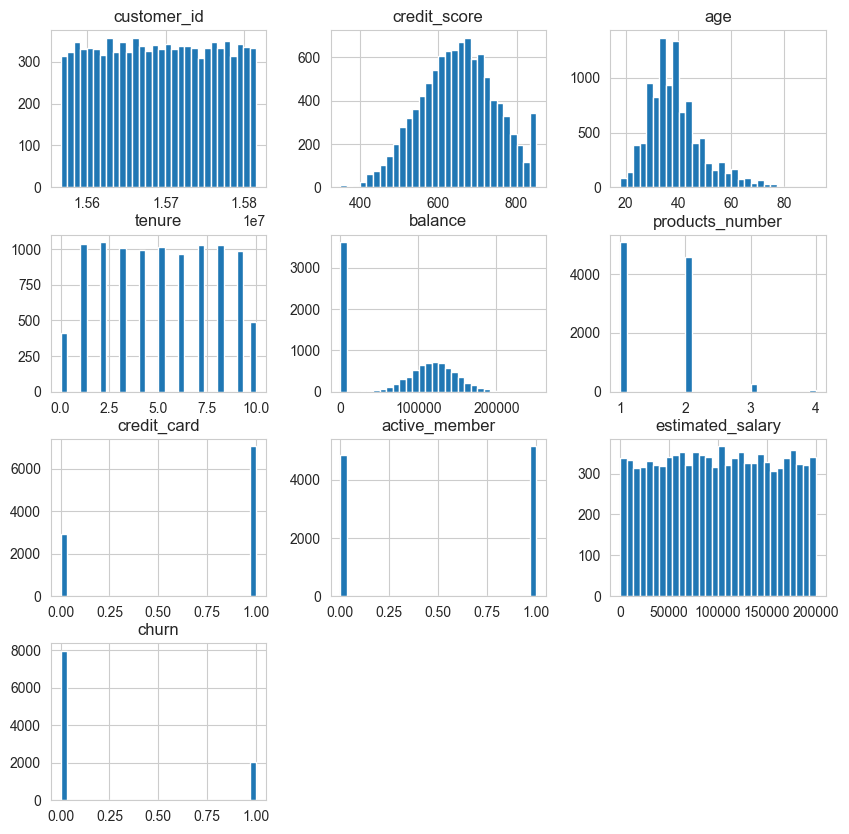

In [63]:
df_ml.hist(bins=30, figsize=(10, 10))
plt.show()

---
# Подготовка данных

Импортируем библиотеки для подготовки:

In [64]:
from sklearn.preprocessing import StandardScaler      # стандартизация
from sklearn.model_selection import train_test_split  # разделение
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score   # оценка качества
from sklearn.model_selection import GridSearchCV  # поиск по сетке

# модели
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
                              ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


Определим функцию для наложения на df тепловой карты:

In [65]:
def highlight_cells(df, col_heatmap=None, cmap='RdYlGn', decimal_places=3):
    """В заданных полях в df накладываем тепловую карту"""

    # Если входной объект - Series, преобразуем его в DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame()

    # Применение стилей к DataFrame
    styled_df1 = df.style

    # К каждому указанному полю применяем тепловую карту
    for col in col_heatmap:
        styled_df1 = styled_df1.background_gradient(subset=[col], cmap=cmap,
                        vmin=df[col].min(), vmax=df[col].max())

    # Форматируем числа в столбцах с тепловой картой
    format_str = f"{{:.{decimal_places}f}}"
    styled_df1 = styled_df1.format(format_str, subset=col_heatmap)

    return styled_df1

Приступим к подготовке данных для построения модели прогнозирования:

In [66]:
# Удалим поле `customer_id`, так как оно не несёт полезной информации
df_ml.drop(columns=['customer_id'], inplace=True)

# Преобразуем с помощью `One-Hot Encoding` категориальные признаки в полях `country` и `gender`:
# После этого в df появятся новые столбцы: `country_Germany`, `country_Spain`, `gender_Male`
df_ml = pd.get_dummies(df_ml, columns=['country', 'gender'], drop_first=True)

# Масштабируем числовые признаки в полях, значения которых могут достигать больших размеров
scaler = StandardScaler()
df_ml[['credit_score', 'age', 'balance', 'estimated_salary']] = scaler.fit_transform(
        df_ml[['credit_score', 'age', 'balance', 'estimated_salary']])

# Проверим баланс классов целевой переменной
df_ml['churn'].value_counts(normalize=True)

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Разделим данные:

In [67]:
# Разделим данные на признаки (X) и целевую переменную (y):
X = df_ml.drop(columns=['churn'])
y = df_ml['churn']

# Разделим данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
# Тестовое обучение модели

Зададим параметры модели, обучим ёё и выполним предсказание меток для тестовых данных:

In [68]:
# Дисбаланс классов в целевой переменной не сильный, используем class_weight='balanced'
model1 = LogisticRegression(class_weight='balanced')

# Обучаем модель
model1.fit(X_train, y_train)

# Предсказание меток для тестовых данных
y_pred = model1.predict(X_test)

Определим какого качества получается модели применяя `LogisticRegression` без сравнения качества прогноза между моделями и без оптимизации гиперпараметров:

In [69]:
# Оценка качества на тестовой выборке
print('Точность: %.3f' % accuracy_score(y_test, y_pred))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
print('ROC-AUC: %.3f' % roc_auc_score(y_test, y_pred))

Точность: 0.714
F1-Score: 0.499
ROC-AUC: 0.709


---
# Определение моделей, выдающей лучший прогноз

Далее построим связку для обучения нескольких нейросетей пока без подбора гиперпараметров и вывод результатов прогноза для каждой сети:

Определим функцию для обучения сетей и выполнения прогноза:

In [70]:
def train_and_predict(X_train, X_test, y_train, y_test, network):

    random_state = 42

    # Выбор модели
    if network == "Logistic Regression":
        model2 = LogisticRegression(max_iter=1000)
    elif network == "Random Forest":
        model2 = RandomForestClassifier(n_estimators=100, random_state=random_state)
    elif network == "Gradient Boosting":
        model2 = GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif network == "SVM (RBF Kernel)":
        model2 = SVC(kernel='rbf', probability=True, random_state=random_state)
    elif network == "K-Nearest Neighbors (KNN)":
        model2 = KNeighborsClassifier(n_neighbors=5)
    elif network == "XGBoost":
        model2 = XGBClassifier(random_state=random_state)
    elif network == "CatBoost":
        model2 = CatBoostClassifier(random_state=random_state, verbose=0)  # verbose=0 для отключения логов
    elif network == "AdaBoost":
        model2 = AdaBoostClassifier(random_state=random_state)
    elif network == "Extra Trees":
        model2 = ExtraTreesClassifier(random_state=random_state)
    elif network == "Multi-layer Perceptron (MLP)":
        model2 = MLPClassifier(random_state=random_state, max_iter=1000)
    elif network == "Gaussian Naive Bayes":
        model2 = GaussianNB()
    elif network == "Decision Tree":
        model2 = DecisionTreeClassifier(random_state=random_state)
    else:
        raise ValueError("Неверный тип модели. Допустимые значения: 1-15.")

    # Обучаем модель
    model2.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model2.predict(X_test)
    y_val_probs = model2.predict_proba(X_test)[:, 1]

    # Вычисляем метрики
    accuracy = round(accuracy_score(y_test, y_val_pred), 3)
    f1score = round(f1_score(y_test, y_val_pred), 3)
    auc = round(roc_auc_score(y_test, y_val_probs), 3)

    return accuracy, f1score, auc

In [71]:
# Модели машинного обучения
neural_network = {1: "Logistic Regression", 2: "Random Forest", 3: "Gradient Boosting", 4: "SVM (RBF Kernel)",
                  5: "K-Nearest Neighbors (KNN)", 6: "XGBoost", 7: "CatBoost", 8: "AdaBoost", 9: "Extra Trees",
                  10: "Multi-layer Perceptron (MLP)", 11: "Gaussian Naive Bayes", 12: "Decision Tree"}

# перебор сетей по очереди
network_set = [neural_network[key] for key in range(1, 13)]

# Создаем пустой DataFrame для аккумуляции данных статистики
df_enumeration = pd.DataFrame(index=network_set, columns=['Accuracy', 'F1_score', 'AUC'])

for network_name in network_set:
    # вызов функции с выполнением прогноза
    accuracy, f1score, auc = train_and_predict(X_train, X_test, y_train, y_test, network=network_name)

    # сохраняем в таблицу замер качества прогноза
    df_enumeration.loc[network_name, ['Accuracy', 'F1_score', 'AUC']] = accuracy, f1score, auc

# Для наглядности накладываем на каждое поле df отдельную тепловую карту
styled_df = highlight_cells(df_enumeration, ['Accuracy', 'F1_score', 'AUC'])

styled_df

Параметры модели CatBoost:
 {'verbose': 0, 'random_state': 42}


,Accuracy,F1_score,AUC
Logistic Regression,0.808,0.284,0.775
Random Forest,0.865,0.583,0.852
Gradient Boosting,0.870,0.605,0.871
SVM (RBF Kernel),0.822,0.243,0.839
K-Nearest Neighbors (KNN),0.832,0.465,0.760
XGBoost,0.849,0.565,0.833
CatBoost,0.870,0.606,0.862
AdaBoost,0.860,0.568,0.848
Extra Trees,0.859,0.562,0.846
Multi-layer Perceptron (MLP),0.864,0.596,0.860



**Лучшие модели в нашем случае:**
- **CatBoost** (`Accuracy=0.87`, `F1=0.606`, `AUC=0.862`).
- **Gradient Boosting** (`Accuracy=0.87`, `F1=0.605`, `AUC=0.871`).

**Почему они лучшие?**
- Высокие значения **всех трёх метрик**, что указывает на сбалансированность модели.
- **F1-score > 0.6** — это сильный показатель для задач с дисбалансом классов (предполагается, что данные несбалансированы, так как Accuracy высокий, а F1 низкий у других моделей).
- **AUC > 0.85** — модель хорошо разделяет классы.

---
# Тонкая настройка моделей

## Тонкая настройка модели CatBoost

Ключевые гиперпараметры:
- iterations: Количество деревьев.
- learning_rate: Скорость обучения.
- depth: Глубина деревьев.
- l2_leaf_reg: Коэффициент L2-регуляризации.

In [73]:
import optuna

def objective(trial):
    # словарь с параметрами
    params = {
            # learning_rate для каждой сети свой. CatBoostClassifier 1e-3, 0.3
            # 1e-3 (0.001) — для плавного обучения. 0.3 — чтобы избежать переобучения и нестабильности.
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', None]),
            'border_count': trial.suggest_int('border_count', 32, 254),
            # значение более 8 даёт риск переобучения. Для регуляризации 6.
            'depth': trial.suggest_int('depth', 4, 8),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 10.0),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 50.0, log=True),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
            'random_strength': trial.suggest_float('random_strength', 1e-3, 1.0, log=True),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'eval_metric': 'F1',  # Оптимизация под F1-score
            'od_type': 'Iter',
            'od_wait': 20,

            'task_type': 'GPU',               # Включаем использование GPU
            'devices': '0',                   # Используем первую видеокарту
            'bootstrap_type': 'Poisson',      # Лучше работает на GPU
            'sampling_frequency': 'PerTree',  # Оптимизация для GPU
            'verbose': False,}

    # Динамическая настройка iterations в зависимости от learning_rate
    if trial.params['learning_rate'] > 0.1:
        params['iterations'] = trial.suggest_int('iterations', 200, 800)
    else:
        params['iterations'] = trial.suggest_int('iterations', 800, 2000)

    # Создаем и обучаем модель
    model3 = CatBoostClassifier(**params)
    model3.fit(X_train, y_train, eval_set=(X_test, y_test),
               early_stopping_rounds=20, use_best_model=True)

    # Прогнозируем классы для тестовой выборки
    y_pred1 = model3.predict(X_test)

    # Вычисляем F1-score
    return f1_score(y_test, y_pred1, average='binary') # для бинарной классификации

# отключение логирования в вывод
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Создаем исследование (направление = максимизация F1-score)
study = optuna.create_study(
    study_name="CatBoostClassifier_1000_n_trials_1",
    direction='maximize',
    storage="sqlite:///optuna_studies/my_study.db", # Сохранять результаты
    load_if_exists=True)  # Продолжить существующее исследование, если оно есть

# optuna-dashboard sqlite:///D:/GitRepo/Portfolio/bank_customer_predict/optuna_studies/my_study.db

study.optimize(objective, n_trials=1000)

# Выводим результаты лучшего trial
print('Лучший trial:')
best_trial = study.best_trial
print(f'  F1-score: {best_trial.value:.4f}')
print('  Параметры:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# # Можно также сохранить лучшую модель
# best_model = CatBoostClassifier(**best_trial.params)
# best_model.fit(X_train, y_train)  # Переобучим на всех данных (можно добавить eval_set)

Лучший trial:
  F1-score: 0.4505
  Параметры:
    learning_rate: 0.2720629528933391
    auto_class_weights: Balanced
    border_count: 32
    depth: 5
    bagging_temperature: 8.120588740552998
    l2_leaf_reg: 8.153797582076715
    min_data_in_leaf: 150
    random_strength: 0.0024220354554000713
    grow_policy: SymmetricTree
    iterations: 493


---
! Важно: в конце обязательно подумать оставить исходные данные с кагле в файле "_a", преобразованные данные в файле "_b". Или ещё доработать преобразование данных!
- сейчас пока для разработки выбраны исходные данные с кагле.
- под итоговые данные в разделе с исследованием доработать текст заметки и выводы.
- в конце вставить информативные графики от plotly: https://plotly.com/python/ml-regression/
- в конце разработки раздела вопросы в разделе по маш обучению сверить с выполненной работой
- после завершения данной части проекта и окончательного определения с данными вернутся к первой части с аналитическим исследованием и: 1) в исследовании текст метки и выводы править под данные 2) написать итоговый вывод 3) проверить в целом проект.